**Face Mask Detection**

Program Machine Learning untuk mendeteksi penggunaan masker. Program dibuat menggunakan metode CNN dengan arsitektur VGG16Net dan MTCNN untuk face detection.


## Mengambil Dataset dari Github


In [1]:
!git clone https://github.com/georgejusen/Skripsi

Cloning into 'Skripsi'...
remote: Enumerating objects: 3988, done.
remote: Counting objects: 100% (232/232), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 3988 (delta 123), reused 216 (delta 107), pack-reused 3756
Receiving objects: 100% (3988/3988), 295.11 MiB | 15.35 MiB/s, done.
Resolving deltas: 100% (125/125), done.
Updating files: 100% (5845/5845), done.


## Mengimpor Libraries yang dibutuhkan

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import argparse
import os
import itertools


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.test.gpu_device_name()

!nvidia-smi




Num GPUs Available:  1
Mon Dec  4 16:12:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    26W /  70W |    309MiB / 15360MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                 

## Preprocessing Datasets


In [3]:
# Inisialisasi nilai Initial Learning Rate, berapa banyak Epoch pelatihan, dan Batch Size
import sys
from PIL import Image
import os
INIT_LR = 1e-4
EPOCHS = 50
BS = 32
n_fold = 7

# Mengambil gambar dari dataset directory, kemudian inisialisasi data dan class gambar
print("Menginput gambar...")

# imagePaths = list(paths.list_images('dataset'))
imagePaths = list(paths.list_images("/content/Skripsi/dataset_small"))
data = []
labels = []

# Melakukan perulangan pada image paths
for imagePath in imagePaths:

    # Mengekstrak class label dari filename
    label = imagePath.split(os.path.sep)[-2]
    # Memuat input gambar (224x224) dan melakukan proses
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # Mengupdate data dan labels lists, berurutan
    data.append(image)
    labels.append(label)

# Mengkonversi data dan label ke dalam NumPy Arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# Melakukan one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
print("Input gambar berhasil")

Menginput gambar...
Input gambar berhasil


### Membuat Data Augmentation


In [4]:

# Membentuk training image generator untuk data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

## Membuat Model Jaringan CNN yang sudah dipelajari sebelumnya (pre-trained convnets)


In [5]:
# Arsitektur jaringan VGG16Net
baseModel = tf.keras.applications.VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

58889256/58889256 [==============================] - 4s 0us/step


### Feature Extraction


In [6]:
baseModel.trainable = False
baseModel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Tahap Pembuatan Model


In [7]:
# Membentuk bagian head dari model yang akan ditempatkan pada base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Menempatkan head model pada base model
model = Model(inputs=baseModel.input, outputs=headModel)
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Mengkompilasi model...
fold 1
Training head model...
Epoch 1/50
42/42 [==============================] - 39s 619ms/step - loss: 0.7347 - accuracy: 0.5414 - val_loss: 0.6377 - val_accuracy: 0.8821
Epoch 2/50
42/42 [==============================] - 19s 438ms/step - loss: 0.6503 - accuracy: 0.6774 - val_loss: 0.5767 - val_accuracy: 0.9389
Epoch 3/50
42/42 [==============================] - 20s 484ms/step - loss: 0.5846 - accuracy: 0.7812 - val_loss: 0.5219 - val_accuracy: 0.9520
Epoch 4/50
42/42 [==============================] - 19s 452ms/step - loss: 0.5217 - accuracy: 0.8753 - val_loss: 0.4686 - val_accuracy: 0.9563
Epoch 5/50
42/42 [==============================] - 18s 423ms/step - loss: 0.4780 - accuracy: 0.8954 - val_loss: 0.4226 - val_accuracy: 0.9563
Epoch 6/50
42/42 [==============================] - 18s 435ms/step - loss: 0.4287 - accuracy: 0.9328 - val_loss: 0.3786 - val_accuracy: 0.9563
Epoch 7/50
42/42 [==============================] - 18s 438ms/step - loss: 0.3941 - accur

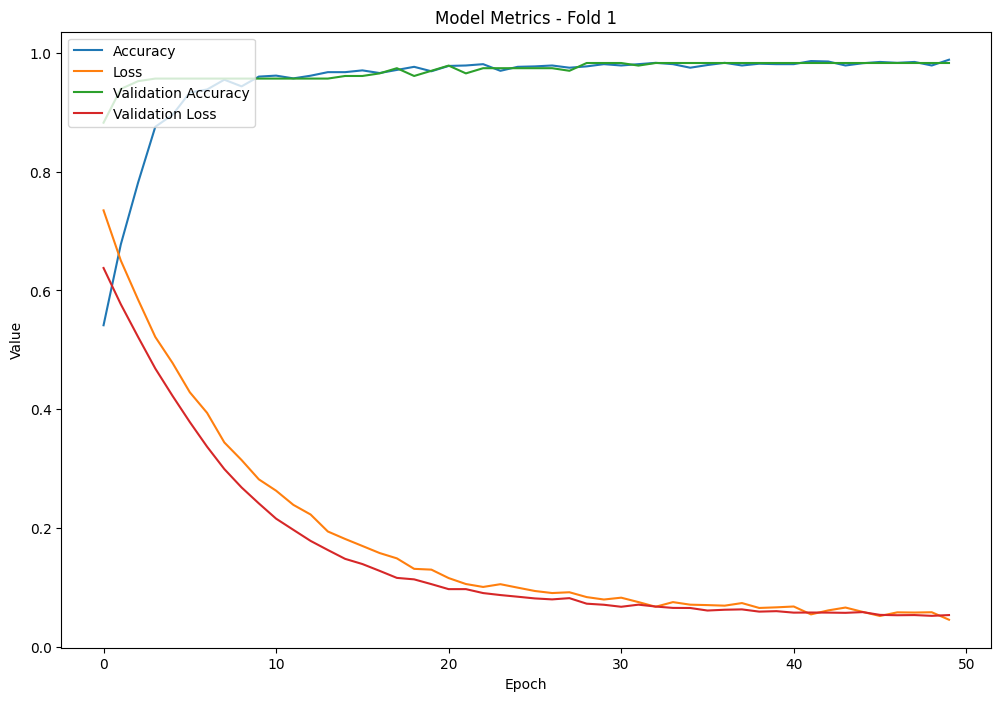

Training time for Fold 1: 980.81 seconds


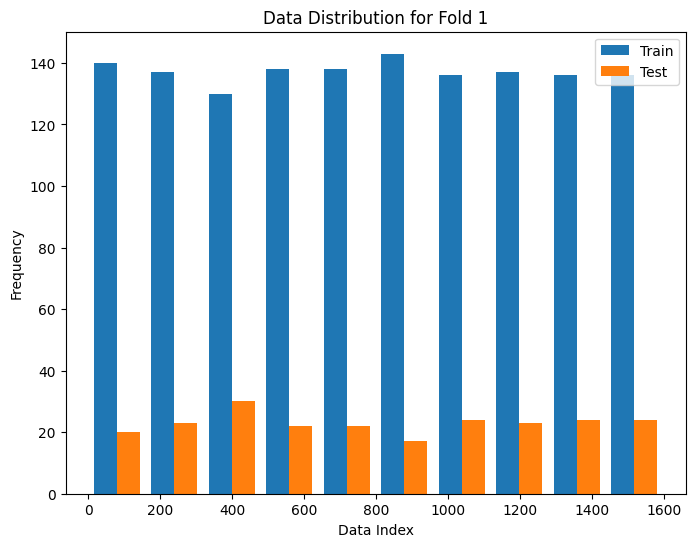

Mengkompilasi model...
fold 2
Training head model...
Epoch 1/50
42/42 [==============================] - 19s 437ms/step - loss: 0.0590 - accuracy: 0.9798 - val_loss: 0.0384 - val_accuracy: 0.9782
Epoch 2/50
42/42 [==============================] - 18s 427ms/step - loss: 0.0553 - accuracy: 0.9858 - val_loss: 0.0402 - val_accuracy: 0.9782
Epoch 3/50
42/42 [==============================] - 18s 434ms/step - loss: 0.0482 - accuracy: 0.9836 - val_loss: 0.0428 - val_accuracy: 0.9782
Epoch 4/50
42/42 [==============================] - 18s 429ms/step - loss: 0.0547 - accuracy: 0.9828 - val_loss: 0.0433 - val_accuracy: 0.9782
Epoch 5/50
42/42 [==============================] - 18s 428ms/step - loss: 0.0530 - accuracy: 0.9858 - val_loss: 0.0378 - val_accuracy: 0.9782
Epoch 6/50
42/42 [==============================] - 18s 433ms/step - loss: 0.0529 - accuracy: 0.9851 - val_loss: 0.0369 - val_accuracy: 0.9782
Epoch 7/50
42/42 [==============================] - 18s 431ms/step - loss: 0.0587 - accur

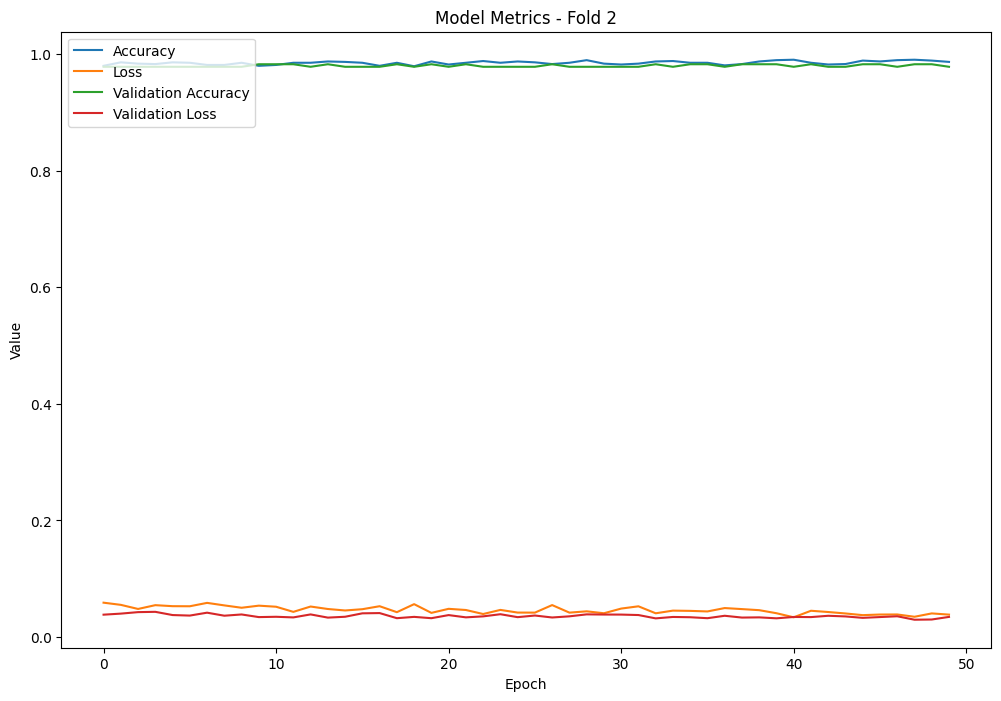

Training time for Fold 2: 971.00 seconds


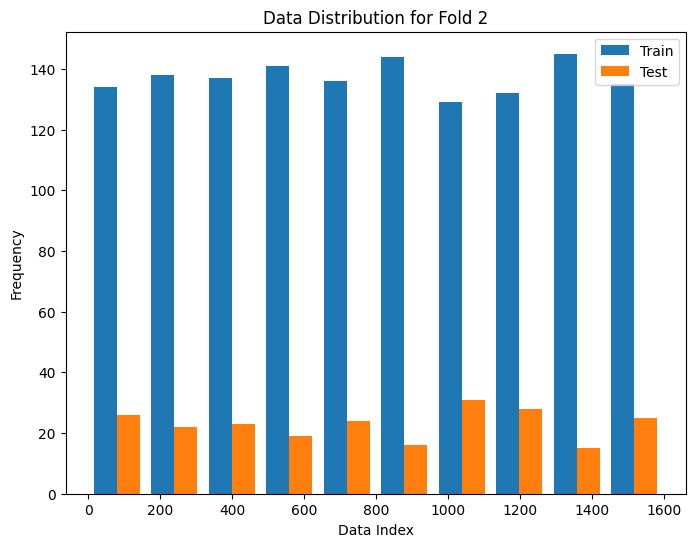

Mengkompilasi model...
fold 3
Training head model...
Epoch 1/50
42/42 [==============================] - 20s 451ms/step - loss: 0.0379 - accuracy: 0.9881 - val_loss: 0.0154 - val_accuracy: 0.9956
Epoch 2/50
42/42 [==============================] - 19s 460ms/step - loss: 0.0383 - accuracy: 0.9858 - val_loss: 0.0146 - val_accuracy: 0.9956
Epoch 3/50
42/42 [==============================] - 19s 439ms/step - loss: 0.0456 - accuracy: 0.9866 - val_loss: 0.0185 - val_accuracy: 0.9956
Epoch 4/50
42/42 [==============================] - 18s 432ms/step - loss: 0.0394 - accuracy: 0.9858 - val_loss: 0.0164 - val_accuracy: 0.9956
Epoch 5/50
42/42 [==============================] - 20s 475ms/step - loss: 0.0297 - accuracy: 0.9903 - val_loss: 0.0161 - val_accuracy: 0.9956
Epoch 6/50
42/42 [==============================] - 19s 441ms/step - loss: 0.0318 - accuracy: 0.9888 - val_loss: 0.0151 - val_accuracy: 0.9956
Epoch 7/50
42/42 [==============================] - 19s 452ms/step - loss: 0.0436 - accur

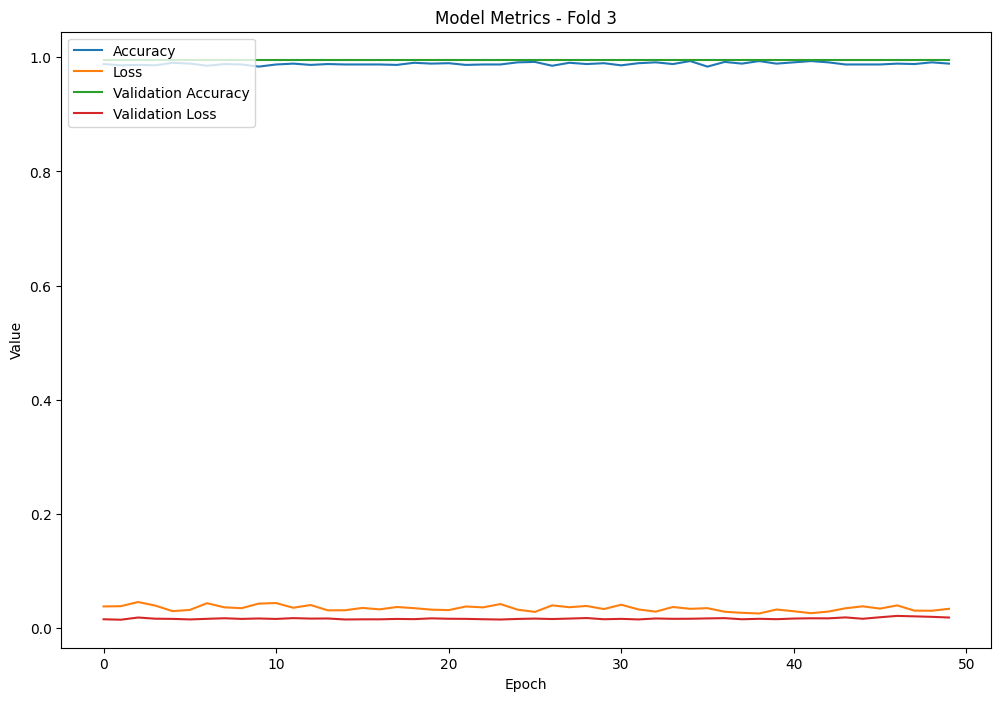

Training time for Fold 3: 999.07 seconds


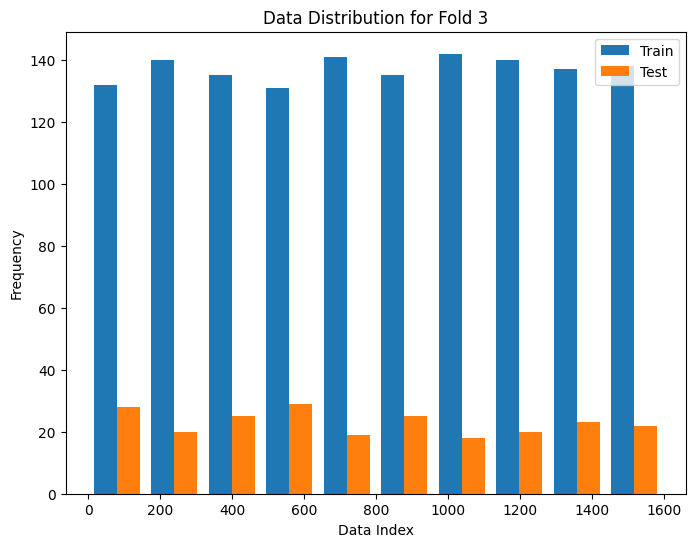

Mengkompilasi model...
fold 4
Training head model...
Epoch 1/50
42/42 [==============================] - 20s 446ms/step - loss: 0.0385 - accuracy: 0.9873 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 2/50
42/42 [==============================] - 20s 471ms/step - loss: 0.0339 - accuracy: 0.9881 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 3/50
42/42 [==============================] - 18s 435ms/step - loss: 0.0300 - accuracy: 0.9888 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 4/50
42/42 [==============================] - 18s 433ms/step - loss: 0.0429 - accuracy: 0.9851 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 5/50
42/42 [==============================] - 20s 467ms/step - loss: 0.0383 - accuracy: 0.9895 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 6/50
42/42 [==============================] - 18s 438ms/step - loss: 0.0326 - accuracy: 0.9903 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 7/50
42/42 [==============================] - 18s 432ms/step - loss: 0.0331 - accur

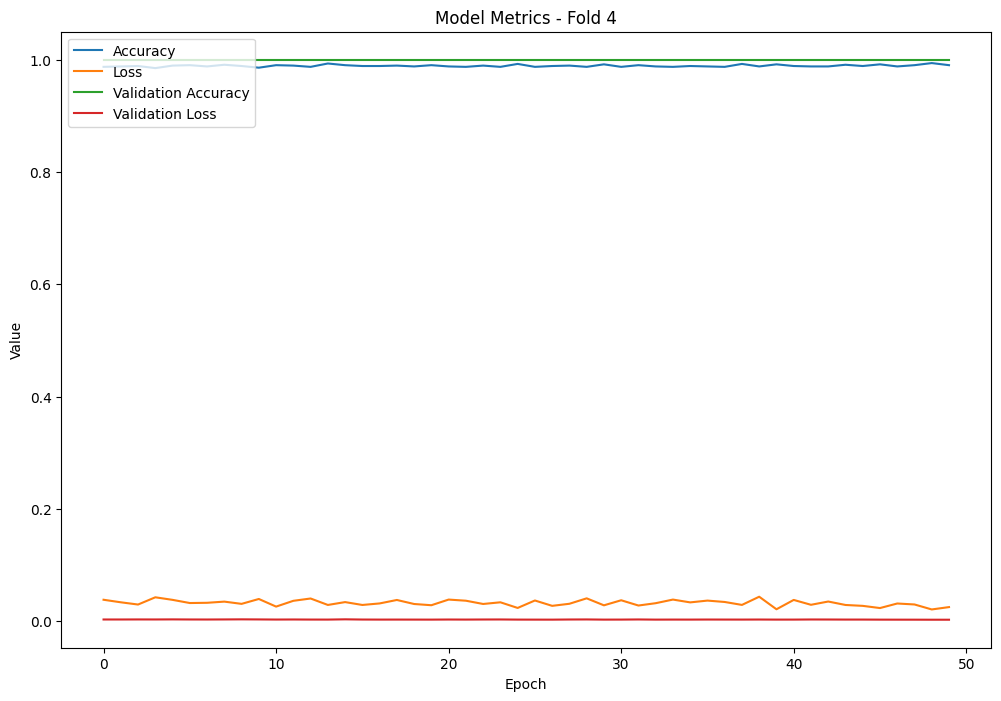

Training time for Fold 4: 952.50 seconds


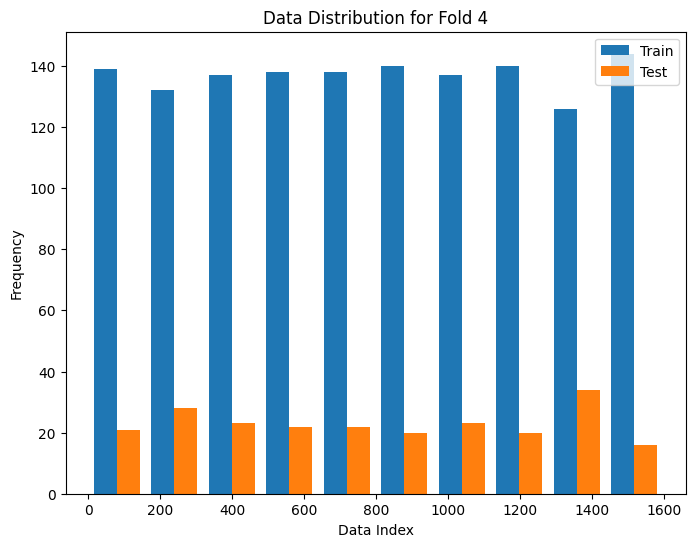

Mengkompilasi model...
fold 5
Training head model...
Epoch 1/50
42/42 [==============================] - 24s 565ms/step - loss: 0.0250 - accuracy: 0.9888 - val_loss: 0.0130 - val_accuracy: 0.9956
Epoch 2/50
42/42 [==============================] - 18s 434ms/step - loss: 0.0276 - accuracy: 0.9918 - val_loss: 0.0118 - val_accuracy: 0.9956
Epoch 3/50
42/42 [==============================] - 19s 452ms/step - loss: 0.0335 - accuracy: 0.9888 - val_loss: 0.0132 - val_accuracy: 0.9956
Epoch 4/50
42/42 [==============================] - 18s 440ms/step - loss: 0.0220 - accuracy: 0.9910 - val_loss: 0.0114 - val_accuracy: 0.9956
Epoch 5/50
42/42 [==============================] - 18s 430ms/step - loss: 0.0222 - accuracy: 0.9903 - val_loss: 0.0106 - val_accuracy: 0.9956
Epoch 6/50
42/42 [==============================] - 20s 472ms/step - loss: 0.0236 - accuracy: 0.9918 - val_loss: 0.0123 - val_accuracy: 0.9956
Epoch 7/50
42/42 [==============================] - 18s 439ms/step - loss: 0.0293 - accur

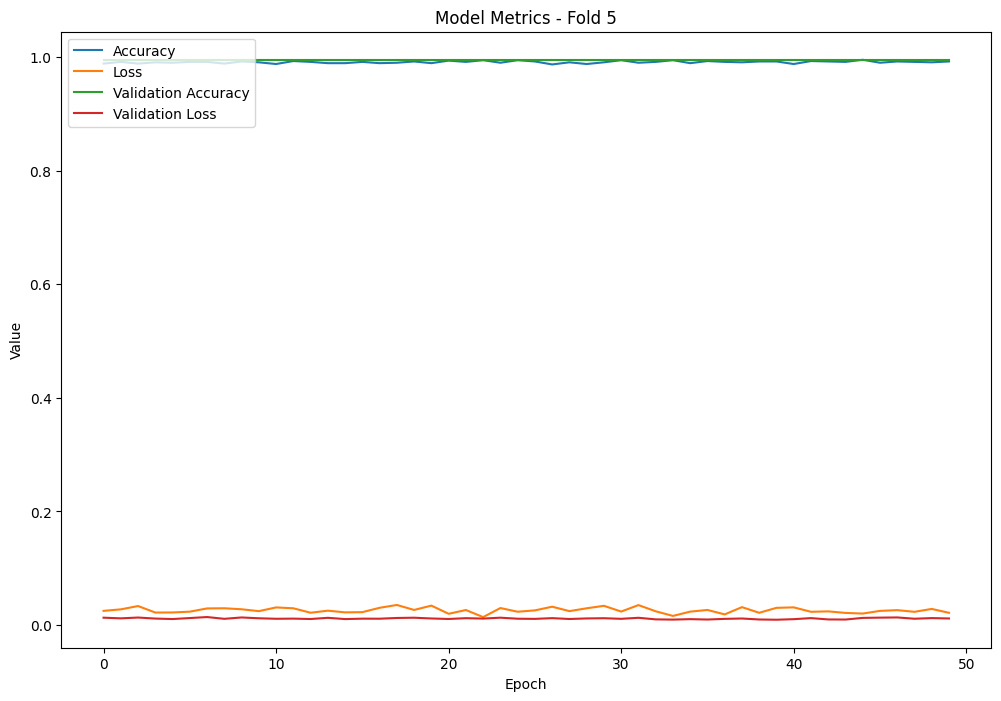

Training time for Fold 5: 1001.94 seconds


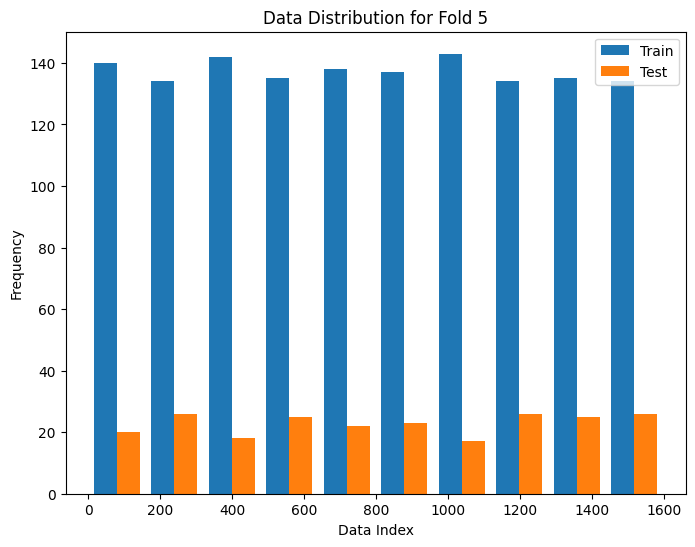

Mengkompilasi model...
fold 6
Training head model...
Epoch 1/50
42/42 [==============================] - 20s 452ms/step - loss: 0.0190 - accuracy: 0.9948 - val_loss: 0.0292 - val_accuracy: 0.9912
Epoch 2/50
42/42 [==============================] - 18s 440ms/step - loss: 0.0243 - accuracy: 0.9925 - val_loss: 0.0278 - val_accuracy: 0.9912
Epoch 3/50
42/42 [==============================] - 18s 436ms/step - loss: 0.0252 - accuracy: 0.9896 - val_loss: 0.0292 - val_accuracy: 0.9912
Epoch 4/50
42/42 [==============================] - 18s 433ms/step - loss: 0.0213 - accuracy: 0.9933 - val_loss: 0.0274 - val_accuracy: 0.9912
Epoch 5/50
42/42 [==============================] - 19s 465ms/step - loss: 0.0325 - accuracy: 0.9888 - val_loss: 0.0268 - val_accuracy: 0.9912
Epoch 6/50
42/42 [==============================] - 18s 441ms/step - loss: 0.0248 - accuracy: 0.9918 - val_loss: 0.0296 - val_accuracy: 0.9912
Epoch 7/50
42/42 [==============================] - 18s 439ms/step - loss: 0.0277 - accur

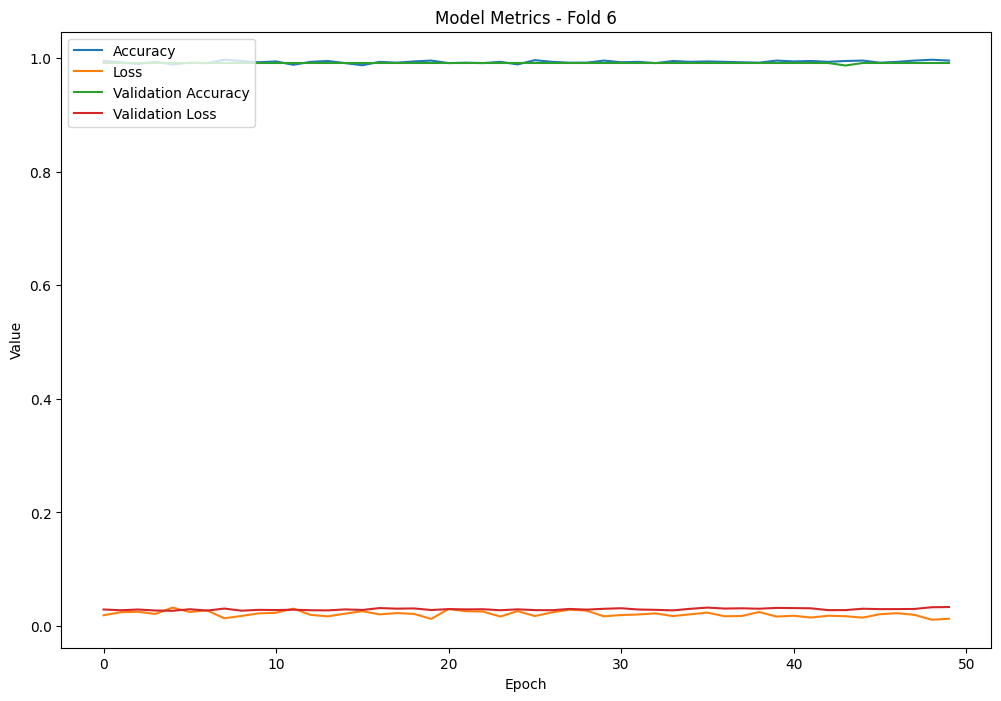

Training time for Fold 6: 980.84 seconds


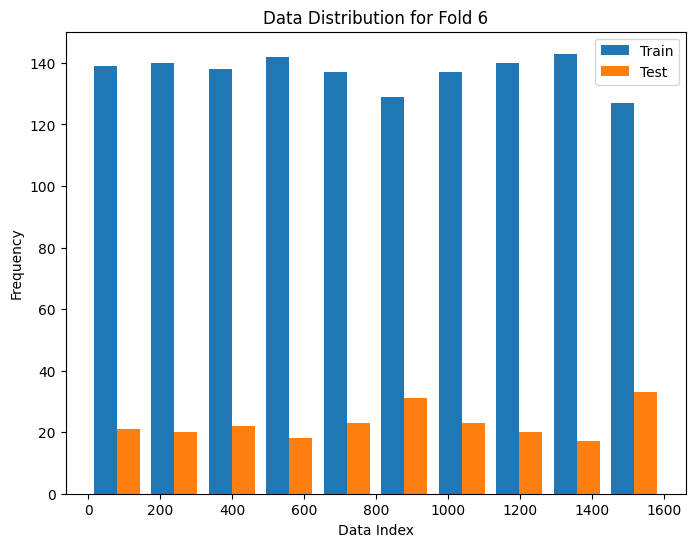

Mengkompilasi model...
fold 7
Training head model...
Epoch 1/50
42/42 [==============================] - 21s 467ms/step - loss: 0.0219 - accuracy: 0.9933 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 2/50
42/42 [==============================] - 19s 447ms/step - loss: 0.0236 - accuracy: 0.9933 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 3/50
42/42 [==============================] - 19s 441ms/step - loss: 0.0157 - accuracy: 0.9940 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 4/50
42/42 [==============================] - 18s 439ms/step - loss: 0.0192 - accuracy: 0.9925 - val_loss: 0.0057 - val_accuracy: 1.0000
Epoch 5/50
42/42 [==============================] - 20s 486ms/step - loss: 0.0224 - accuracy: 0.9896 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 6/50
42/42 [==============================] - 19s 445ms/step - loss: 0.0138 - accuracy: 0.9948 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 7/50
42/42 [==============================] - 19s 447ms/step - loss: 0.0184 - accur

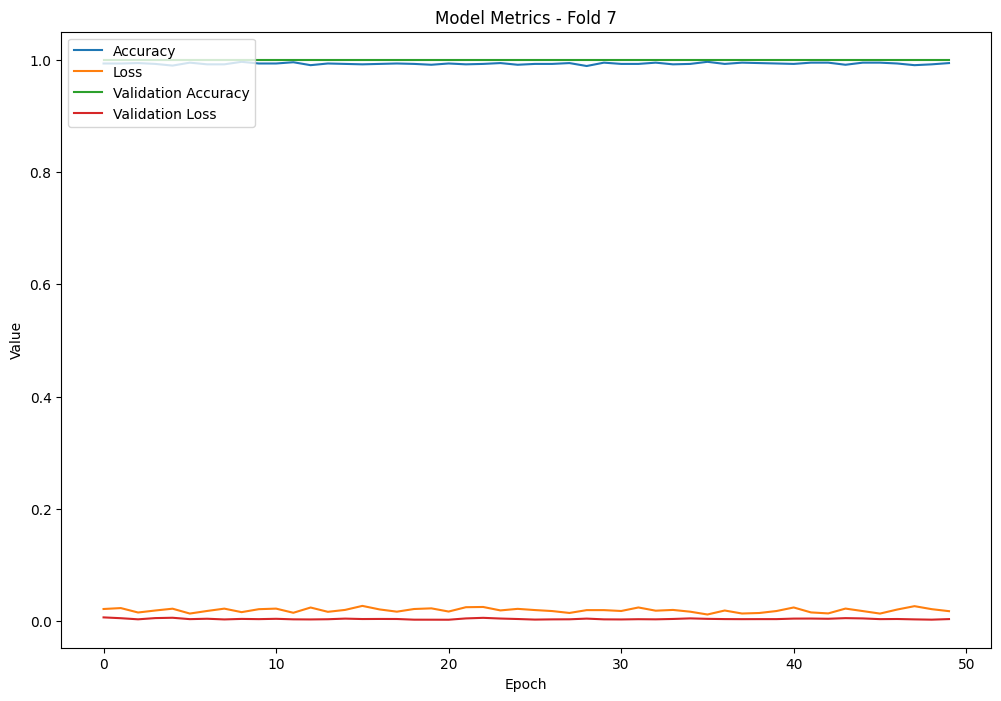

Training time for Fold 7: 991.53 seconds


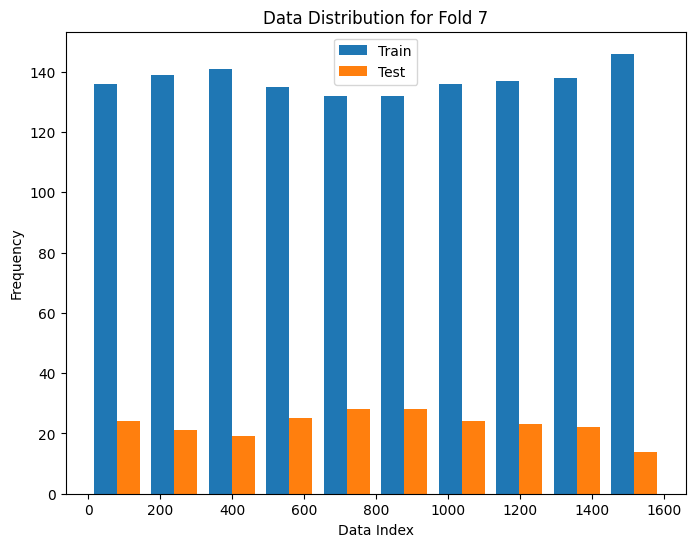

Fold 1 - Accuracy: 0.9825, F1 Score: 0.9825, Precision: 0.9828, Recall: 0.9823
Training time for Fold 1: 980.81 seconds
Fold 2 - Accuracy: 0.9782, F1 Score: 0.9782, Precision: 0.9790, Recall: 0.9783
Training time for Fold 2: 971.00 seconds
Fold 3 - Accuracy: 0.9956, F1 Score: 0.9956, Precision: 0.9954, Recall: 0.9959
Training time for Fold 3: 999.07 seconds
Fold 4 - Accuracy: 1.0000, F1 Score: 1.0000, Precision: 1.0000, Recall: 1.0000
Training time for Fold 4: 952.50 seconds
Fold 5 - Accuracy: 0.9956, F1 Score: 0.9956, Precision: 0.9955, Recall: 0.9957
Training time for Fold 5: 1001.94 seconds
Fold 6 - Accuracy: 0.9912, F1 Score: 0.9912, Precision: 0.9906, Recall: 0.9919
Training time for Fold 6: 980.84 seconds
Fold 7 - Accuracy: 1.0000, F1 Score: 1.0000, Precision: 1.0000, Recall: 1.0000
Training time for Fold 7: 991.53 seconds


In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.model_selection import KFold

kf = KFold(n_splits=n_fold, shuffle=True)

fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1_scores = []
all_histories = []  # Menyimpan semua riwayat pelatihan untuk setiap fold
fold_training_times = []  # Menyimpan waktu pelatihan untuk setiap fold

# Perulangan pada seluruh base model
fold = 1
for train_index, test_index in kf.split(data):
    print("Mengkompilasi model...")
    print("fold", fold)

    train_data, train_labels = data[train_index], labels[train_index]
    test_data, test_labels = data[test_index], labels[test_index]

    opt = tf.keras.optimizers.legacy.RMSprop(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

    model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

    print("Training head model...")

    start_time = time.time()  # Catat waktu awal

    history = model.fit(
        aug.flow(train_data, train_labels, batch_size=BS),
        steps_per_epoch=len(train_data) // BS,
        validation_data=(test_data, test_labels),
        validation_steps=len(test_data) // BS,
        epochs=EPOCHS)

    end_time = time.time()  # Catat waktu akhir
    training_time = end_time - start_time
    fold_training_times.append(training_time)

    all_histories.append(history)

    loss, accuracy = model.evaluate(test_data, test_labels, verbose=0)
    fold_accuracies.append(accuracy)

    # Prediksi dan hitung f1 score, presisi, dan recall
    predictions = model.predict(test_data)
    predictions = np.round(predictions)
    f1 = f1_score(test_labels, predictions, average='macro')
    precision = precision_score(test_labels, predictions, average='macro')
    recall = recall_score(test_labels, predictions, average='macro')
    fold_f1_scores.append(f1)
    fold_precisions.append(precision)
    fold_recalls.append(recall)

    # Plotting untuk setiap fold
    plt.figure(figsize=(12, 8))

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['val_loss'])

    plt.title(f'Model Metrics - Fold {fold}')
    plt.ylabel('Value')
    plt.xlabel('Epoch')
    plt.legend(['Accuracy', 'Loss', 'Validation Accuracy', 'Validation Loss'], loc='upper left')

    plt.show()

    print(f"Training time for Fold {fold}: {training_time:.2f} seconds")

    # Membuat plot untuk distribusi data fold
    plt.figure(figsize=(8, 6))
    plt.hist([train_index, test_index], bins=10, label=['Train', 'Test'])
    plt.title(f'Data Distribution for Fold {fold}')
    plt.xlabel('Data Index')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    fold += 1

# Print fold accuracies, f1 scores, precisions, and recalls
for fold, accuracy, f1, precision, recall, training_time in zip(range(1, fold+1), fold_accuracies, fold_f1_scores, fold_precisions, fold_recalls, fold_training_times):
    print(f"Fold {fold} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    print(f"Training time for Fold {fold}: {training_time:.2f} seconds")



## Evaluasi Jaringan


Confusion Matrix for Fold 7:
[[111   0]
 [  0 117]]


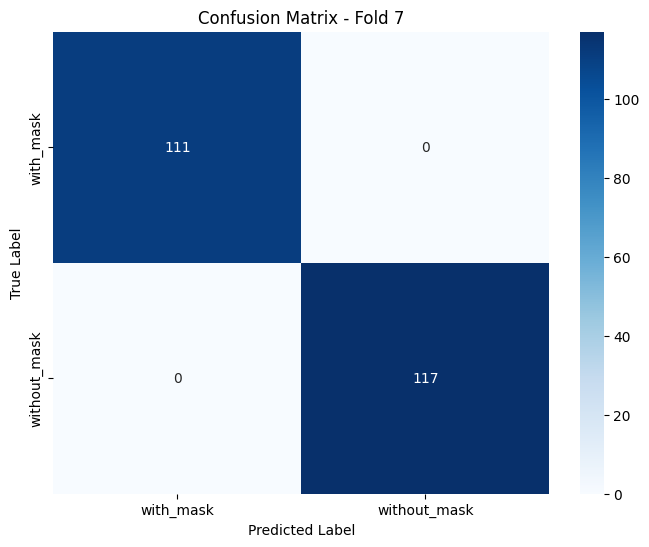

In [9]:
from sklearn.metrics import confusion_matrix
# Hitung confusion matrix
conf_matrix = confusion_matrix(test_labels.argmax(axis=1), predictions.argmax(axis=1))

# Tampilkan confusion matrix
print(f"Confusion Matrix for Fold {fold}:\n{conf_matrix}")

# Atau, Anda juga dapat menggunakan library seaborn untuk tampilan yang lebih baik
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.title(f'Confusion Matrix - Fold {fold}')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [10]:

# Convert model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
tflite_model_filename = 'model.tflite'
with open(tflite_model_filename, 'wb') as f:
    f.write(tflite_model)

print(f"TensorFlow Lite model saved to {tflite_model_filename}")


TensorFlow Lite model saved to model.tflite
